In [3]:
pip install textblob keras tensorflow matplotlib wordcloud

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing required libraries
import pickle
import nltk
import pandas as pd

# preprocessing dependencies
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# model dependencies
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Reshape
from sklearn.model_selection import train_test_split 
from keras.metrics import Precision, Recall

# plot dependencies
import matplotlib.pyplot as plt
import wordcloud

In [5]:
# load dataset
reddit = pd.read_csv('Reddit_Data.csv')
reddit.head()
data_v1 = reddit

In [6]:
# check the distribution of values
reddit['category'].value_counts()

 1    15830
 0    13142
-1     8277
Name: category, dtype: int64

In [7]:
# check NaN values
print(reddit.isna().sum())
# drop NaN values
df = reddit.dropna()

clean_comment    100
category           0
dtype: int64


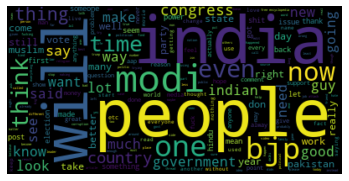

In [8]:
# check common words with the word cloud
common_words=''
for i in data_v1.clean_comment:  
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
# clean dataset
def cleaning(df, stop_words):
    df['clean_comment'] = df['clean_comment'].apply(lambda x:' '.join(x.lower() for x in str(x).split()))
    # Replacing the digits/numbers
    df['clean_comment'] = df['clean_comment'].str.replace('^\d+\s|\s\d+\s|\s\d+$', '', regex =True)
    # Removing stop words
    df['clean_comment'] = df['clean_comment'].apply(lambda x:' '.join(x for x in str(x).split() if x not in stop_words))
    # Lemmatization
    df['clean_comment'] = df['clean_comment'].apply(lambda x:' '.join([Word(x).lemmatize() for x in x.split()]))
    return df

stop_words = stopwords.words('english')
data_v1 = cleaning(data_v1, stop_words)
data_v1.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal wrappi...,0
4,benefit may want read living buddha living chr...,1


In [10]:
# Encoded the target column
lb=LabelEncoder()
data_v1['category'] = lb.fit_transform(data_v1['category'])
data_v1.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,2
1,buddhism much lot compatible christianity espe...,2
2,seriously say thing first get complex explain ...,0
3,learned want teach different focus goal wrappi...,1
4,benefit may want read living buddha living chr...,2


In [11]:
# tokenize input text
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['clean_comment'].values)
X = tokenizer.texts_to_sequences(data_v1['clean_comment'].values)
X = pad_sequences(X)

In [12]:
# saving tokenizer
with open('tokenizer_LSTM_reddit.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# Splitting the data into training and testing
y = pd.get_dummies(data_v1['category'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [14]:
# create model architecture
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy', Precision(), Recall()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 438, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 438, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 3)                 531       
                                                                 
Total params: 269,619
Trainable params: 269,619
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# run model 
batch_size = 32
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = 5, batch_size = batch_size, 
                    verbose = 'auto')

Epoch 1/5
  2/815 [..............................] - ETA: 29:47 - loss: 1.0927 - accuracy: 0.4219 - precision: 0.0000e+00 - recall: 0.0000e+00  

KeyboardInterrupt: 

In [ ]:
# Analyze the model using the test data
model.evaluate(X_test, y_test)

In [ ]:
def plot_training_hist(history):
    '''Plot history for accuracy and loss'''
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc = 'best')
    #second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc = 'best')
    
plot_training_hist(history)

In [ ]:
# check the model's performance on testing data
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use the model to do the prediction
    y_pred = model.predict(X_test)
    # compute the confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test), axis = 1), np.argmax(y_pred, axis = 1))
    # plot confusion matrix
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, cmap = plt.cm.Blues, annot = True, fmt = 'd',
                xticklabels = sentiment_classes,
                yticklabels = sentiment_classes)
    plt.title('Confusion matrix', fontsize = 16)
    plt.xlabel('Actual label', fontsize = 12)
    plt.ylabel('Predicted label', fontsize = 12)
    
plot_confusion_matrix(model, X_test, y_test)

In [ ]:
# save model
model.save('model_LSTM_reddit.h5')